In [3]:
import os
# for cuBLAS deterministic workspace (Volta+ GPUs)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

import random
import numpy as np
import torch

# ---- PyTorch deterministic settings ----
torch.use_deterministic_algorithms(True)        # 1)
torch.backends.cudnn.deterministic    = True    # 2)
torch.backends.cudnn.benchmark        = False
# disable TF32
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32       = False

# ---- Seed everything ----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [4]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pydicom, cv2, torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import multiprocessing as mp

mp.set_start_method('fork', force=True)

Cohort Exploration

In [4]:
patient_df = pd.read_csv('/Users/jiwoo_noh/Downloads/admissions.csv')
dicom_df   = pd.read_csv('/Users/jiwoo_noh/Downloads/cxr-record-list.csv')

dicom_filtered = dicom_df[
    dicom_df['subject_id'].astype(str).str.startswith(('10', '12', '15', '17', '18', '19')) #removed 13
]

merged = dicom_filtered.merge(
    patient_df[['subject_id', 'ethnicity']],
    on='subject_id',
    how='inner'
)

to_drop = ['OTHER', 'UNKNOWN', 'UNABLE TO OBTAIN', 'AMERICAN INDIAN/ALASKA NATIVE']

merged = merged[~merged['ethnicity'].isin(to_drop)]

result = merged[['subject_id', 'ethnicity', 'path']]

result.to_csv(
    '/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv',
    index=False
)


In [5]:
labels_df = pd.read_csv('/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv')

eth_df = labels_df[['subject_id','ethnicity']].drop_duplicates()
counts = eth_df['subject_id'].value_counts()
ambiguous_ids = counts[counts > 1].index.tolist()

if ambiguous_ids:
    print(f"Removing {len(ambiguous_ids)} patients with inconsistent ethnicity:", ambiguous_ids)

labels_df = labels_df[~labels_df['subject_id'].isin(ambiguous_ids)].reset_index(drop=True)
labels = labels_df['ethnicity']
subject_id = labels_df['subject_id']

Removing 214 patients with inconsistent ethnicity: [19919017, 18110020, 19014160, 19011622, 19936081, 18341991, 10942097, 15874847, 15057166, 10731206, 17183367, 15784514, 19565063, 10264068, 12604466, 12704996, 10949720, 18730486, 15506972, 15140950, 10056612, 12789108, 17102345, 17101277, 15574754, 17350899, 12034618, 15416392, 19299811, 19671332, 12297145, 12106493, 10270108, 15509202, 12697173, 10720865, 15966360, 17813449, 19763886, 18566742, 15071748, 17981662, 10367781, 15666867, 10827166, 12903377, 19821816, 10190829, 15608828, 17922113, 15853461, 19962126, 15800920, 17382149, 18905773, 12580408, 18532084, 19023015, 10253747, 17548885, 12125322, 18334912, 12021934, 18333592, 15677158, 15326328, 17720066, 17809813, 18728113, 12379909, 17447497, 12497543, 19575197, 18155258, 17930009, 15600427, 19674244, 18942108, 10756520, 18769702, 15393401, 12077819, 18767874, 12250460, 18962557, 19729296, 12673327, 12081472, 19151064, 19731136, 12847427, 10692049, 12450853, 17163115, 17852330

ethnicity
WHITE                     969968
BLACK/AFRICAN AMERICAN    358786
HISPANIC/LATINO            91197
ASIAN                      38288
Name: count, dtype: int64
29955


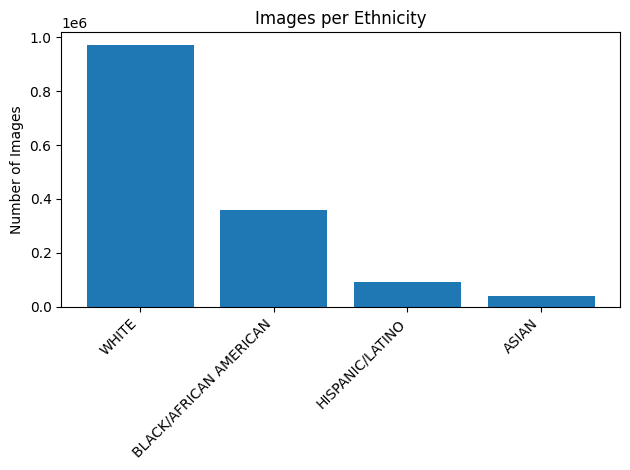

In [6]:
# calculate data demographics
race_counts = labels_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = labels_df['subject_id'].unique()

print(len(unique_subject))

# plotting race distribution
plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DICOM Preprocessing

In [7]:
import os, pydicom, pandas as pd
from pydicom import config
config.use_gdcm_handler = True

local_path_stem = '/Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/'

valid_rows = []
labels_dict = {}

for _, row in labels_df.iterrows():
    patient_id = row['subject_id']
    full_path  = os.path.join(local_path_stem, row['path'])
    if not os.path.exists(full_path):
        continue

    try:
        ds = pydicom.dcmread(full_path, force=True)
        _  = ds.pixel_array   # will throw if unreadable
    except Exception as e:
        # print(f"Skipping corrupted {full_path}: {e}")
        continue

    new_row = row.copy()
    new_row['path'] = row['path']        
    valid_rows.append(new_row)

    # store for later dataset creation
    labels_dict[(patient_id, full_path)] = row['ethnicity']

# save the new list of patients (this is the data we will actually have access to)
valid_df = pd.DataFrame(valid_rows)

unique_labels = sorted(valid_df['ethnicity'].unique())
label2idx     = {lab: i for i, lab in enumerate(unique_labels)}
idx2label     = {i: lab for lab, i in label2idx.items()}
num_classes   = len(unique_labels)

print("Classes:", unique_labels)
print("Mapping:", label2idx)

# valid_df.to_csv('downloaded_data_info.csv', index=False)


Classes: ['ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'WHITE']
Mapping: {'ASIAN': 0, 'BLACK/AFRICAN AMERICAN': 1, 'HISPANIC/LATINO': 2, 'WHITE': 3}


ethnicity
WHITE                     6702
BLACK/AFRICAN AMERICAN    4334
HISPANIC/LATINO            775
ASIAN                       52
Name: count, dtype: int64
Number of unique patients:252


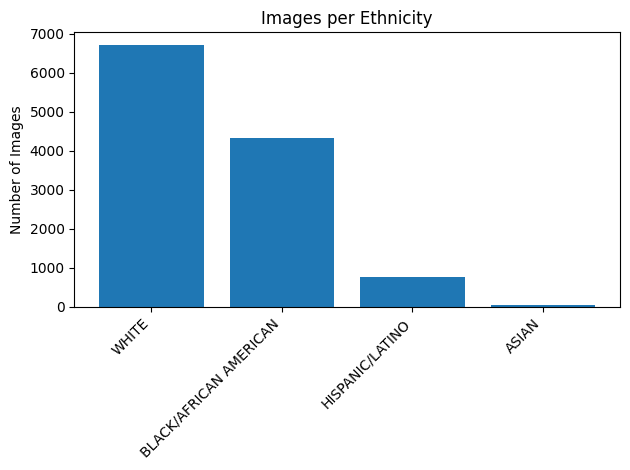

In [8]:
## plot the final patient demographics after filtering and downloading 
race_counts = valid_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = valid_df['subject_id'].unique()

print(f'Number of unique patients:{len(unique_subject)}')

plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# by patient train/validation/test split
# stratified by ethnicity
patient_labels = valid_df.groupby('subject_id')['ethnicity'].first()
unique_patients = patient_labels.index.tolist()
patient_label_list = patient_labels.tolist()

# 70 train, val 20, test 10
test_patients, temp_patients = train_test_split(
    unique_patients,
    test_size=0.9,
    stratify=patient_label_list,  # <— keeps your test class‐balance
    random_state=42
)
# now split temp_patients into train / val
temp_labels = patient_labels.loc[temp_patients].tolist()
train_patients, val_patients = train_test_split(
    temp_patients,
    test_size=0.222222,          # ≈20% of original full cohort
    stratify=temp_labels,       
    random_state=42
)

print("Patient size: \n")
print(f"Train size: {len(train_patients)}")
print(f"Val   size: {len(val_patients)}")
print(f"Test  size: {len(test_patients)}")

# complete training, validation, testing datasets because patients have more than one dicom
train_items = []
val_items = []
test_items = []

for (patient_id, path) in labels_dict.keys():
    if patient_id in train_patients:
        train_items.append((patient_id, path))
    elif patient_id in val_patients:
        val_items.append((patient_id, path))
    elif patient_id in test_patients:
        test_items.append((patient_id, path))
    else:
        print("Patient ID: {patient_id} not found in any split but is in the processed images. Something is seriously wrong. Taco.")


# output lists of patient, path pairs as keys
# need to have labels_dict dictionary loaded in --> tensors as items in this dictionary

NameError: name 'valid_df' is not defined

In [6]:
import os
import pydicom
import numpy as np
import random
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# if you ever use CUDA:
torch.cuda.manual_seed_all(SEED)
# make cuDNN deterministic (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# 1) Dataset class 
class DicomDataset(Dataset):
    def __init__(self, items, labels_dict, label2idx,
                 transform=None, strong_transform=None):
        self.items            = items
        self.labels           = labels_dict
        self.label2idx        = label2idx
        self.transform        = transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pid, path = self.items[idx]
        ds  = pydicom.dcmread(path)
        arr = ds.pixel_array.astype('float32')
        arr = (arr - arr.min()) / (arr.ptp() + 1e-6)
        img = Image.fromarray((arr * 255).astype('uint8'))

        raw_label = self.labels[(pid, path)]
        # if we have a strong_transform AND this is a minority class, use it
        if (
            raw_label in ['ASIAN', 'HISPANIC/LATINO']
            and self.strong_transform is not None
        ):
            img = self.strong_transform(img)
        else:
            # fallback to the normal one (must be set)
            img = self.transform(img)

        label = self.label2idx[raw_label]
        return img, label


# 2) Compute train‐set mean & std 
def compute_mean_std(loader):
    mean = 0.0
    var  = 0.0
    n    = 0
    for imgs, _ in loader:
        # imgs: [B, 1, H, W]
        b = imgs.size(0)
        imgs = imgs.view(b, imgs.size(1), -1)   # [B, C, H*W]
        mean += imgs.mean(2).sum(0)
        var  += imgs.var(2, unbiased=False).sum(0)
        n    += b
    mean /= n
    var  /= n
    std   = torch.sqrt(var)
    return mean, std


stats_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   # yields [1,H,W] in [0,1]
])

stats_loader = DataLoader(
    DicomDataset(train_items, labels_dict, label2idx, transform=stats_transform),
    batch_size=32, shuffle=False, num_workers=0
)

train_mean, train_std = compute_mean_std(stats_loader)
print(f"Train mean: {train_mean.item():.4f},  std: {train_std.item():.4f}")

# compute per pixel image for mask later 
# stats_loader yields batches of shape [B,1,224,224] in [0,1]
pixel_sum   = torch.zeros((224,224))
num_samples = 0

for imgs, _ in stats_loader:
    # imgs.squeeze(1): [B,224,224]
    pixel_sum   += imgs.squeeze(1).sum(dim=0)
    num_samples += imgs.size(0)

mean_image = pixel_sum / num_samples  # shape [224,224]

plt.imshow(mean_image.numpy(), cmap='gray')
plt.title("Dataset Mean Image")
plt.axis('off')
plt.show()
torch.save(mean_image, 'mean_image.pt')

# 3) final transforms
train_transform = transforms.Compose([ # data augmentation to prevent overfitting
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

# Stronger transform for asian and hispanic population
strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.8,1.2), shear=10),
    transforms.ToTensor(),                     
    transforms.RandomErasing(p=0.3),         
    transforms.Normalize([train_mean.item()], 
                         [train_std.item()]),
])

NameError: name 'train_items' is not defined

In [7]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm

# ─── FIX ALL SOURCES OF RANDOMNESS ─────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# ─── Device setup ─────────────────────────────────────────────────────────
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# ─── Determine number of classes ──────────────────────────────────────────
unique_labels = sorted(set(labels_dict.values()))
num_classes   = len(unique_labels)
print(f"Classes ({num_classes}): {unique_labels}")

# ─── Hyperparameter grid ─────────────────────────────────────────────────
batch_size_options    = [16]
learning_rate_options = [1e-4]
weight_decay_options  = [1e-3]

records = []

for batch_size in batch_size_options:
    for learning_rate in learning_rate_options:
        for weight_decay in weight_decay_options:

            print(f"\n======== batch_size={batch_size}, "
                  f"learning_rate={learning_rate}, "
                  f"weight_decay={weight_decay} ========")

            # ─── DataLoaders (num_workers=0 for determinism) ────────────────
            train_loader = DataLoader(
                DicomDataset(train_items, labels_dict, label2idx,
                             transform=train_transform,
                             strong_transform=strong_transform),
                batch_size=batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=True
            )
            val_loader = DataLoader(
                DicomDataset(val_items, labels_dict, label2idx,
                             transform=val_transform),
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )
            test_loader = DataLoader(
                DicomDataset(test_items, labels_dict, label2idx,
                             transform=val_transform),
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )

            # ─── Build model ───────────────────────────────────────────────
            model = densenet121(pretrained=True)
            old_conv = model.features.conv0
            new_conv = nn.Conv2d(
                in_channels=1,
                out_channels=old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=(old_conv.bias is not None)
            )
            with torch.no_grad():
                new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
                if old_conv.bias is not None:
                    new_conv.bias[:] = old_conv.bias
            model.features.conv0 = new_conv
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
            model = model.to(device)

            # ─── Loss, optimizer, scheduler ───────────────────────────────
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(
                model.parameters(),
                lr=learning_rate,
                weight_decay=weight_decay
            )
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            # ─── Training loop with tqdm & metrics ────────────────────────
            best_val_accuracy = 0.0
            for epoch in range(1, 16):
                # — Training —
                model.train()
                train_loss_sum = train_correct = train_total = 0
                train_bar = tqdm(train_loader, desc=f"Epoch {epoch:02d} ▶ Train", leave=False)
                for imgs, labs in train_bar:
                    imgs, labs = imgs.to(device), labs.to(device)
                    optimizer.zero_grad()
                    outputs = model(imgs)
                    loss = criterion(outputs, labs)
                    loss.backward()
                    optimizer.step()

                    bs = labs.size(0)
                    train_loss_sum += loss.item() * bs
                    preds = outputs.argmax(dim=1)
                    train_correct += (preds == labs).sum().item()
                    train_total   += bs

                    train_bar.set_postfix(
                        loss=f"{train_loss_sum/train_total:.4f}",
                        acc =f"{train_correct/train_total:.4f}"
                    )

                # — Validation —
                model.eval()
                val_loss_sum = val_correct = val_total = 0
                val_bar = tqdm(val_loader, desc=f"Epoch {epoch:02d} ▶ Val  ", leave=False)
                with torch.no_grad():
                    for imgs, labs in val_bar:
                        imgs, labs = imgs.to(device), labs.to(device)
                        outputs = model(imgs)
                        loss = criterion(outputs, labs)

                        bs = labs.size(0)
                        val_loss_sum += loss.item() * bs
                        preds = outputs.argmax(dim=1)
                        val_correct += (preds == labs).sum().item()
                        val_total   += bs

                        val_bar.set_postfix(
                            loss=f"{val_loss_sum/val_total:.4f}",
                            acc =f"{val_correct/val_total:.4f}"
                        )

                avg_val_acc = val_correct / val_total
                scheduler.step()
                best_val_accuracy = max(best_val_accuracy, avg_val_acc)

                print(f"Epoch {epoch:02d} ▶ Val Acc: {avg_val_acc:.4f}")

            print(f"→ Best validation accuracy = {best_val_accuracy:.4f}")

            # ─── Save and record ──────────────────────────────────────────
            fname = f"model_bs_{batch_size}_lr_{learning_rate}_wd_{weight_decay}.pt"
            torch.save(model.state_dict(), fname)
            records.append({
                "batch_size":       batch_size,
                "learning_rate":    learning_rate,
                "weight_decay":     weight_decay,
                "best_val_accuracy": best_val_accuracy,
                "model_file":       fname
            })

# ─── Summarize all runs & rename best ───────────────────────────────────────
results_df = pd.DataFrame(records).sort_values("best_val_accuracy", ascending=False).reset_index(drop=True)
print("\nAll runs sorted by validation accuracy:")
print(results_df.to_string(index=False))

best_file = results_df.loc[0, "model_file"]
os.replace(best_file, "densenet_final_test.pt")
print(f"Renamed {best_file} → densenet_final_test.pt")


Using device: mps


NameError: name 'labels_dict' is not defined

In [9]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

batch_size = test_loader.batch_size
# chunk your flat list into the same batch‐sized groups
batched_items = [
    test_items[i : i+batch_size]
    for i in range(0, len(test_items), batch_size)
]

all_pids, all_paths, all_preds, all_probs, all_truths = [], [], [], [], []

model.load_state_dict(torch.load("reproduceable_densenet.pt"))
model.eval()

# Compute test accuracy ───────────────────────────────────────────────
correct = 0
total   = 0
with torch.no_grad():
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        out   = model(imgs)
        preds = out.argmax(dim=1)
        correct += (preds == labs).sum().item()
        total   += labs.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

with torch.no_grad():
    for (imgs, labs), batch in zip(test_loader, batched_items):
        imgs = imgs.to(device)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1)
        preds = probs.argmax(dim=1)

        labs_cpu  = labs.cpu().tolist()
        preds_cpu = preds.cpu().tolist()
        probs_cpu = probs.cpu().tolist()

        # now `batch` is a list of (pid,path) of length == imgs.size(0)
        for (pid,path), truth_idx, pred_idx, prob in zip(
            batch, labs_cpu, preds_cpu, probs_cpu
        ):
            all_pids.append(pid)
            all_paths.append(path)
            all_truths.append(idx2label[truth_idx])
            all_preds.append(idx2label[pred_idx])
            all_probs.append(prob)

import pandas as pd
df = pd.DataFrame({
    "subject_id":   all_pids,
    "dicom_path":   all_paths,
    "true_label":   all_truths,
    "predicted":    all_preds,
    "probabilities": all_probs,
})

df.to_csv("best_model_pred_final.csv", index=False)
print("Saved best_model_pred_final.csv with", len(df), "rows.")


NameError: name 'test_loader' is not defined

Classification Report:

                        precision    recall  f1-score   support

                 ASIAN       0.00      0.00      0.00         3
BLACK/AFRICAN AMERICAN       0.91      0.87      0.89        45
       HISPANIC/LATINO       0.00      0.00      0.00         8
                 WHITE       0.96      0.99      0.97       323

              accuracy                           0.95       379
             macro avg       0.47      0.46      0.47       379
          weighted avg       0.92      0.95      0.94       379



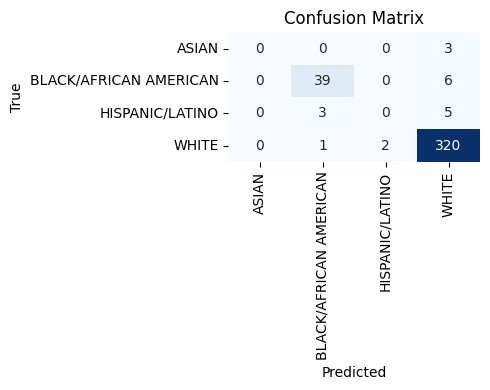

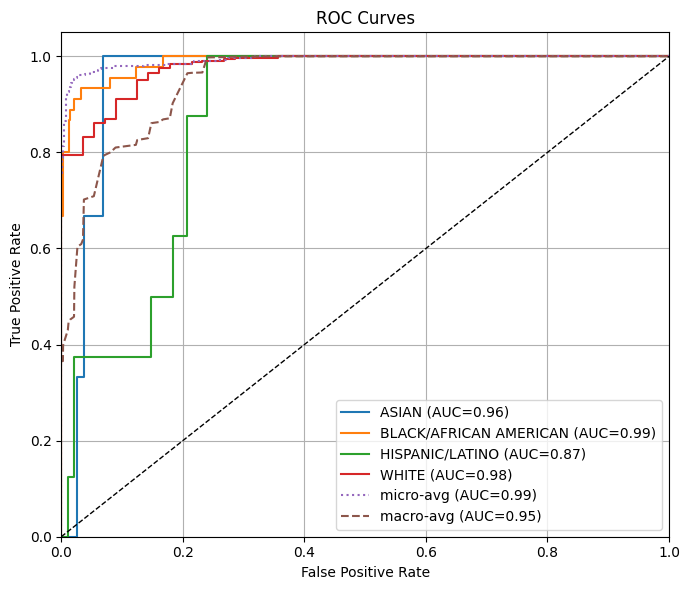

In [ ]:
import os, random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1) Collect predictions, labels, and probabilities
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        out  = model(imgs)                  # logits
        probs = torch.softmax(out, dim=1)   # [B,C]
        preds = probs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labs.numpy())
        all_probs.append(probs.cpu().numpy())

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs  = np.vstack(all_probs)  # shape (N, C)

# 2) Classification report & per‑class precision/recall/f1/support
print("Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    labels=list(range(len(unique_labels))),
    target_names=unique_labels,
    zero_division=0
))

# 3) Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(unique_labels))))
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=unique_labels,
            yticklabels=unique_labels,
            cmap="Blues", cbar=False,
            ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.tight_layout()

# save to disk
# fig.savefig("confusion_matrix_best_final.jpg", dpi=300)
plt.show()
plt.close(fig)

# 4) ROC Curves & AUC
n_classes = len(unique_labels)
fpr, tpr, roc_auc = {}, {}, {}

# per-class ROC & AUC
for i in range(n_classes):
    y_true_i  = (all_labels == i).astype(int)
    y_score_i = all_probs[:, i]
    if 0 < y_true_i.sum() < len(y_true_i):
        fpr[i], tpr[i], _ = roc_curve(y_true_i, y_score_i)
        roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average (treat every element of every class equally)
y_true_bin = np.eye(n_classes)[all_labels]  # one-hot encode
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(), all_probs.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average (unweighted mean of class‐wise curves)
# 1) aggregate all fpr points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if i in fpr]))
# 2) interpolate each class’s tpr at these points, then average
mean_tpr = np.zeros_like(all_fpr)
seen = 0
for i in range(n_classes):
    if i in fpr:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        seen += 1
mean_tpr /= seen
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5) Plot & save to disk
fig, ax = plt.subplots(figsize=(7,6))
for i in range(n_classes):
    if i in roc_auc:
        ax.plot(fpr[i], tpr[i],
                label=f"{unique_labels[i]} (AUC={roc_auc[i]:.2f})")
ax.plot(fpr["micro"], tpr["micro"],
        label=f"micro-avg (AUC={roc_auc['micro']:.2f})", linestyle=':')
ax.plot(fpr["macro"], tpr["macro"],
        label=f"macro-avg (AUC={roc_auc['macro']:.2f})", linestyle='--')
ax.plot([0,1], [0,1], "k--", lw=1)

ax.set_xlim(0,1)
ax.set_ylim(0,1.05)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend(loc="lower right")
ax.grid(True)
plt.tight_layout()

# save figure
# fig.savefig("roc_curves_best_final.jpg", dpi=300)
plt.show()
plt.close(fig)


In [ ]:
import random
import shap
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn

# 1) Build a small background set on CPU
bg_size = 50
all_inputs = [train_loader.dataset[i][0] for i in range(len(train_loader.dataset))]
background = torch.stack(random.sample(all_inputs, bg_size)).cpu()

# 2) Move model to CPU, disable inplace ReLU, wrap in GradientExplainer
model_cpu = model.to('cpu').eval()
for module in model_cpu.modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False
explainer = shap.GradientExplainer(model_cpu, background)

results = []
for cls_idx, cls_name in enumerate(unique_labels):
    found_tensor = None

    # 3) Find one correctly classified example (all on CPU)
    for imgs, labs in test_loader:
        imgs_cpu = imgs.cpu()
        labs_cpu = labs.cpu()
        with torch.no_grad():
            preds = model_cpu(imgs_cpu).argmax(1)
        for b in range(imgs_cpu.size(0)):
            if labs_cpu[b].item() == cls_idx and preds[b].item() == cls_idx:
                found_tensor = imgs_cpu[b:b+1].clone().requires_grad_(True)
                break
        if found_tensor is not None:
            break

    if found_tensor is None:
        print(f"⚠️  no correct example for {cls_name}, skipping")
        continue

    # 4) Compute SHAP values
    shap_values = explainer.shap_values(found_tensor)
    shap_map    = shap_values[cls_idx][0, 0]  # H×W

    pixel = found_tensor.detach().numpy()[0, 0]
    results.append((cls_name, pixel, shap_map))

# 5) Plot results
n = len(results)
fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))

for i, (cls_name, pixel, shap_map) in enumerate(results):
    norm = np.abs(shap_map)
    norm = (norm - norm.min())/(norm.max() - norm.min() + 1e-8)
    cam = cv2.resize(norm, (pixel.shape[1], pixel.shape[0]), interpolation=cv2.INTER_LINEAR)
    heat    = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)[..., ::-1] / 255.0
    overlay = 0.6*np.dstack([pixel]*3) + 0.4*heat

    # original image
    ax = axes[i, 0]
    ax.imshow(pixel, cmap='gray')
    ax.set_title(cls_name)
    ax.axis('off')

    # SHAP overlay
    ax = axes[i, 1]
    ax.imshow(overlay)
    ax.set_title("SHAP overlay")
    ax.axis('off')

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1976960897445679..1.3268728577389437].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1976960897445679..1.5944286823272704].


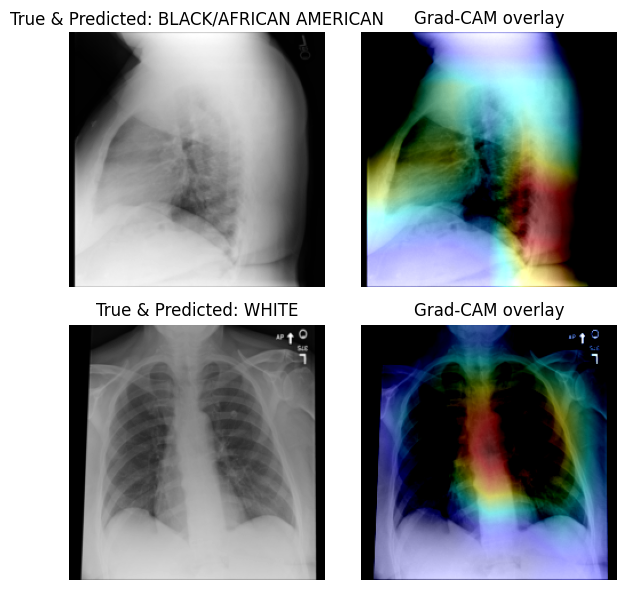

In [ ]:
# Grad-CAM

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# assume `model`, `test_loader`, and `unique_labels` are already defined
device = next(model.parameters()).device
model.eval()

# 1) pick one correctly classified example per class
sample_imgs, sample_labels = [], []
for cls_idx, cls_name in enumerate(unique_labels):
    found = False
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        with torch.no_grad():
            preds = model(imgs).argmax(1)
        for b in range(imgs.size(0)):
            if labs[b].item() == cls_idx and preds[b].item() == cls_idx:
                sample_imgs.append(imgs[b].cpu())
                sample_labels.append(cls_idx)
                found = True
                break
        if found:
            break

if len(sample_imgs) == 0:
    raise RuntimeError("No correctly predicted samples found!")

# stack into (N,1,H,W)
sample_imgs = torch.stack(sample_imgs)

# 2) register hooks on the last DenseNet feature map
activations = {}
gradients   = {}
def forward_hook(module, inp, out):
    activations['feat'] = out
def backward_hook(module, grad_in, grad_out):
    gradients['grad'] = grad_out[0]

target_layer = model.features.norm5
fh = target_layer.register_forward_hook(forward_hook)
bh = target_layer.register_backward_hook(backward_hook)

# 3) compute Grad-CAM maps
cams = []
for i in range(sample_imgs.size(0)):
    x = sample_imgs[i:i+1].to(device)
    model.zero_grad()
    out = model(x)
    cls = sample_labels[i]
    out[0, cls].backward()

    feat = activations['feat'][0]    # C×h×w
    grad = gradients  ['grad'][0]    # C×h×w
    weights = grad.mean(dim=(1,2))   # C
    cam = (weights[:,None,None] * feat).sum(dim=0).cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cams.append(cam)

# remove hooks
fh.remove()
bh.remove()

# 4) visualize: N×2 grid
n = sample_imgs.size(0)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, 3*n), squeeze=False)

for i in range(n):
    # original image
    img = sample_imgs[i,0].numpy()  # H×W

    # process CAM → upsample → colourmap → overlay
    cam  = cams[i]
    cam  = (cam - cam.min())/(cam.max()-cam.min()+1e-8)
    cam  = cv2.resize(cam, (img.shape[1], img.shape[0]),
                      interpolation=cv2.INTER_LINEAR)
    heat = cv2.applyColorMap((cam*255).astype(np.uint8),
                              cv2.COLORMAP_JET)[...,::-1]/255.0
    overlay = 0.4*heat + 0.6*np.dstack([img]*3)

    # plot original
    ax = axes[i,0]
    lbl = unique_labels[sample_labels[i]]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True & Predicted: {lbl}")
    ax.axis('off')

    # plot Grad-CAM overlay
    ax = axes[i,1]
    ax.imshow(overlay)
    ax.set_title("Grad-CAM overlay")
    ax.axis('off')

plt.tight_layout()
plt.show()


# GRAD CAM HERE

In [1]:
import pandas as pd
import os
import glob
import pydicom
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision.models import densenet121

# 1) Pick your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Load the state dict
state_dict = torch.load("reproduceable_densenet.pt", map_location="cpu")

# 3) Instantiate a fresh DenseNet121 (no pretrained weights)
model = densenet121(pretrained=False)

# 4) Patch the first conv to accept 1‐channel input (you did this at train time)
old_conv = model.features.conv0
new_conv = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=(old_conv.bias is not None)
)
with torch.no_grad():
    # average the original 3‐channel weights into 1 channel
    new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
    if old_conv.bias is not None:
        new_conv.bias[:]   = old_conv.bias
model.features.conv0 = new_conv

# 5) Rebuild the classifier to match the number of classes in your state_dict
#    (we infer it from the saved weight tensor shape)
num_classes = state_dict["classifier.weight"].shape[0]
in_feats    = model.classifier.in_features
model.classifier = nn.Linear(in_feats, num_classes)

# 6) Load weights & move to device
model.load_state_dict(state_dict)
model = model.to(device).eval()

# ─── 1) Load & filter your CSV ───────────────────────────────────────────────
df = pd.read_csv("best_model_pred_final.csv")

# keep only correctly predicted
df = df[df.true_label == df.predicted]

# exclude ASIAN and HISPANIC/LATINO
exclude = {"ASIAN", "HISPANIC/LATINO"}
df = df[~df.true_label.isin(exclude)].reset_index(drop=True)

# ─── 2) Set up Grad-CAM hooks ────────────────────────────────────────────────
activations = {}
gradients   = {}

def forward_hook(module, inp, out):
    activations['feat'] = out

def backward_hook(module, grad_in, grad_out):
    gradients['grad'] = grad_out[0]

# assume `model` is your densenet121 instance on `device`
target_layer = model.features.norm5
fh = target_layer.register_forward_hook(forward_hook)
bh = target_layer.register_backward_hook(backward_hook)

# ─── 3) Prepare input/output paths ──────────────────────────────────────────
test_root  = "/Users/jiwoo_noh/Downloads/test_data"
output_dir = "/Users/jiwoo_noh/Downloads/gradcam_results"
os.makedirs(output_dir, exist_ok=True)

# ─── 4) Loop over each filtered test case ───────────────────────────────────
for _, row in df.iterrows():
    fname   = os.path.basename(row.dicom_path)
    matches = glob.glob(os.path.join(test_root, "**", fname), recursive=True)
    if not matches:
        print(f"⚠️  File not found in test_data: {fname}")
        continue
    dicom_path = matches[0]

    # ---- load & normalize DICOM pixel array ----
    ds  = pydicom.dcmread(dicom_path, force=True)
    arr = ds.pixel_array.astype('float32')
    arr = (arr - arr.min()) / (arr.ptp() + 1e-6)
    img = Image.fromarray((arr * 255).astype('uint8'))

    # apply your validation transform (must be defined earlier)
    x = val_transform(img).unsqueeze(0).to(device)

    # ---- forward + backward on the true class ----
    model.zero_grad()
    out = model(x)
    cls_idx = unique_labels.index(row.true_label)
    out[0, cls_idx].backward()

    # ---- build the raw CAM mask ----
    feat    = activations['feat'][0]   # C×h×w
    grad    = gradients['grad'][0]     # C×h×w
    weights = grad.mean(dim=(1,2))     # C
    cam     = (weights[:,None,None] * feat).sum(dim=0).cpu().detach().numpy()
    cam     = np.maximum(cam, 0)
    cam     = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam     = cv2.resize(cam, (arr.shape[1], arr.shape[0]),
                         interpolation=cv2.INTER_LINEAR)

    # ---- build the RGB overlay ----
    heat    = cv2.applyColorMap((cam*255).astype('uint8'),
                                cv2.COLORMAP_JET)[...,::-1] / 255.0
    overlay = 0.6 * np.dstack([arr]*3) + 0.4 * heat

    # derive base filename
    base, _ = os.path.splitext(fname)

    # ---- save raw CAM as .pt (float32) ----
    cam_t = torch.from_numpy(cam).float()                       # H×W
    torch.save(cam_t, os.path.join(output_dir, f"{base}_cam.pt"))

    # ---- save overlay tensor as .pt (float32 C×H×W) ----
    overlay_t = torch.from_numpy(overlay).permute(2,0,1).float()
    torch.save(overlay_t, os.path.join(output_dir, f"{base}_overlay.pt"))

    # ---- save PNG ----
    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f"{base}.png"),
                bbox_inches='tight', pad_inches=0)
    plt.close()

# ─── 5) Clean up hooks ────────────────────────────────────────────────────────
fh.remove()
bh.remove()


/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✔️  Skipping 8159799c-7615c0ba-9676dd65-8b0cd6ed-96872c8f, outputs already exist.
✔️  Skipping b9a08a39-c53ad784-99673387-d9140a2f-cbc1dbde, outputs already exist.
✔️  Skipping 163e7408-e7e88bfd-ae448fe2-484a43ec-23ebcf71, outputs already exist.
✔️  Skipping fbc0acfa-ae0bbb10-37a0c81e-bff2aced-678b58b7, outputs already exist.
✔️  Skipping 4c329d77-162e3abb-df1731fc-a0f2354f-4777a58e, outputs already exist.
✔️  Skipping a4ed7ed0-c2305148-b7b09a2e-ec63d023-ef9fd8df, outputs already exist.
✔️  Skipping 6a8f19a4-2030fcda-b0f13ba9-b050a6a1-aa07e72a, outputs already exist.
✔️  Skipping 7ff22806-8d18e0c8-5d2e1bcc-638b22a0-70654bb1, outputs already exist.
✔️  Skipping ed231cb9-58b5647e-672e03e3-d43be791-c485128e, outputs already exist.
✔️  Skipping f24ba3b1-8a4cc77f-23ad8f8c-5c3dca7d-77e2c0da, outputs already exist.
✔️  Skipping 12fd2ed8-5a501563-a86d9388-5ba1a246-2ac9104b, outputs already exist.
✔️  Skipping 5d2545e0-ea3ad600-6a2fa53d-e9336b30-cf8d3179, outputs already exist.
✔️  Skipping bbe

NameError: name 'val_transform' is not defined